## 1) PACKAGES AND LIBRARIES INSTALLATION 
(TO DO: explain why we need each package)

In [1]:
!pip install 'plotnine[all]'
!pip install wordcloud
!pip install spacy
!python -m spacy download en
!pip install -U textblob
!python -m textblob.download_corpora
!pip install vaderSentiment

     |████████████████████████████████| 9.2MB 2.8MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
Requirement already up-to-date: textblob in /usr/local/lib/python3.6/dist-packages (0.15.3)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/c

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
import nltk

from wordcloud import WordCloud,STOPWORDS
from plotnine import *
from spacy.lang.en import English
from textblob import TextBlob
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk import ngrams
from nltk.stem import WordNetLemmatizer
from yellowbrick.draw import manual_legend
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## 2) DATABASE
The main data was download from Kaggle
https://www.kaggle.com/crowdflower/twitter-airline-sentiment

### 2.1) Web scraping data
The idea here is to increase our data set. We consider relevant to add the **total amount of followers** and if the **account is verified** or not for each twitter account of our database.

Find below a small sample. We will upload another file with all this the data asap.

### 2.2) Loading of dataset


In [0]:
# The new dataset 
tweets = pd.read_csv("https://raw.githubusercontent.com/SarahBuechner/DMML2019_Team_Google/master/data/Tweets.csv")


In [4]:
# Dataframe tweets shape
print(tweets.shape)
# Data types
print(tweets.dtypes)

(12265, 18)
Unnamed: 0                        int64
tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
Followers                         int64
Verified                           bool
dtype: object


## 3) DATA CLEANING
*May be we can include here the data cleaning from Machine Learning section*

In [0]:
# Drop the columns we don't use and converting tweet_created to datetime
try:
  tweets = tweets.drop(columns=['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord', 'user_timezone'])
except KeyError:
  print("The columns have already been removed")
finally:
  tweets['tweet_created'] = pd.to_datetime(tweets['tweet_created'])

## 4) EXPLORATORY DATA ANALYSIS

### 4.1) Sentiment Analysis by Airline
We want to visualize the **distribution sentiment analysis by company**.


The most common class is negative mood = 63.66%


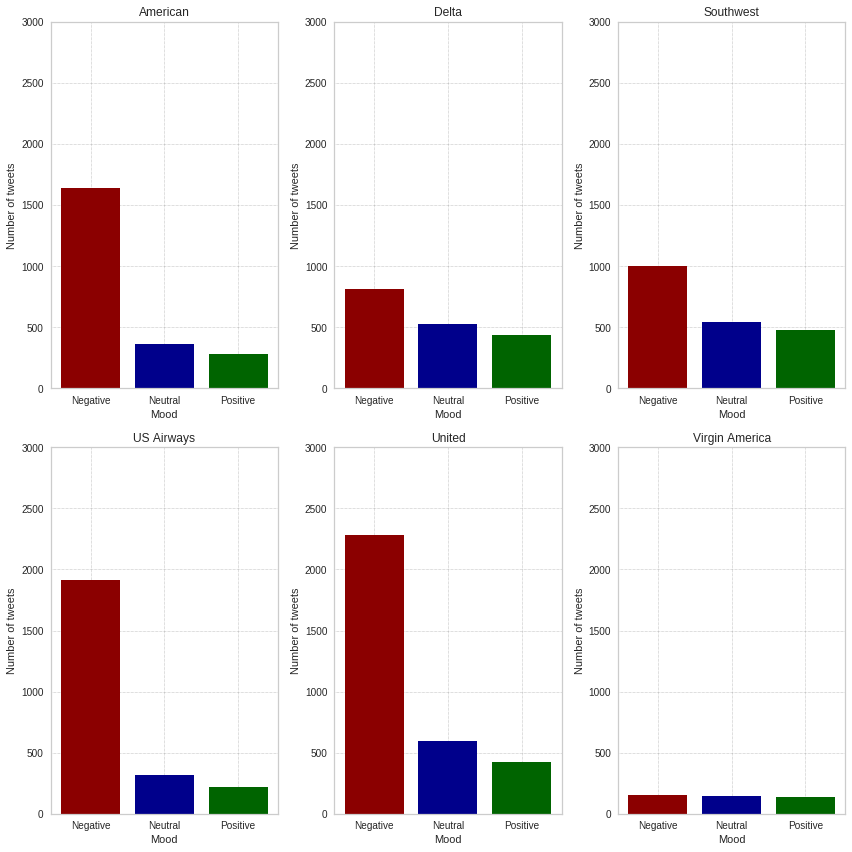

In [6]:
def sentiment_by_airline(Airline):
  df=tweets[tweets['airline']==Airline]
  count=df['airline_sentiment'].value_counts()
  Index = [1,2,3]
  plt.bar(Index,count,color=['darkred', 'darkblue', 'darkgreen'])
  plt.xticks(Index,['Negative','Neutral','Positive'])
  plt.ylabel('Number of tweets')
  plt.xlabel('Mood')
  plt.title(Airline)
  plt.ylim(0,3000)
  plt.grid(which='major', linestyle=':', linewidth='0.5', color='grey')

airlines = ["American", "Delta", "Southwest", "US Airways", "United", "Virgin America"]
plt.figure(1,figsize=(12, 12))


for airline in airlines:
  plt.subplot(231 + airlines.index(airline))
  sentiment_by_airline(airline)
plt.tight_layout()

count=tweets['airline_sentiment'].value_counts()
print("The most common class is negative mood = "+"{:.2%}".format(count[0]/sum(count[0:3])))


### 4.2) Negative Reason by Airline
In the previous graph we saw that the most common class was the *Negative mood*. Now we want to visualize the **negative ratings clustered on topics**.

The 3 main negative topics of American are: (1) Customer Service Issue, (2) Cancelled Flight and (3) Late Flight
The 3 main negative topics of Delta are: (1) Late Flight, (2) Customer Service Issue and (3) Can't Tell
The 3 main negative topics of Southwest are: (1) Customer Service Issue, (2) Cancelled Flight and (3) Can't Tell
The 3 main negative topics of US Airways are: (1) Customer Service Issue, (2) Late Flight and (3) Can't Tell
The 3 main negative topics of United are: (1) Customer Service Issue, (2) Late Flight and (3) Can't Tell
The 3 main negative topics of Virgin America are: (1) Customer Service Issue, (2) Flight Booking Problems and (3) Cancelled Flight


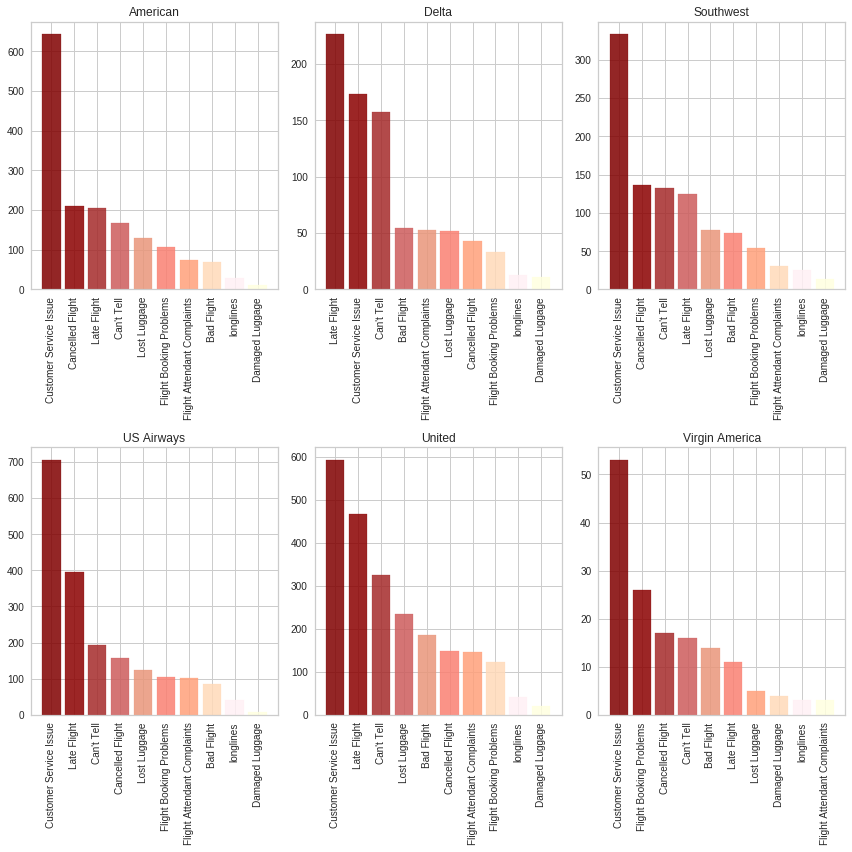

In [7]:
cmap = ['maroon', 'darkred', 'brown', 'indianred', 'darksalmon', 'salmon', 'lightsalmon', 'peachpuff', 'lavenderblush', 'lightyellow']
def negative_reason(Airline):
  df=tweets[tweets['airline']== Airline]
  Neg_reasons_values = df['negativereason'].value_counts(sort=True)
  Neg_reasons_labels = dict(df['negativereason'].value_counts(sort=True))
  Index = range(len(Neg_reasons_values))
  barplot = plt.bar(Index,Neg_reasons_values, alpha = 0.85)
  
  plt.xticks(Index,Neg_reasons_labels, rotation = 90)
  plt.title(Airline)

  for color in cmap:
    barplot[cmap.index(color)].set_color(color)
  
  return ("The 3 main negative topics of " + Airline + " are: (1) " + list(Neg_reasons_labels.keys())[0] + 
  ", (2) " + list(Neg_reasons_labels.keys())[1] + " and (3) " + list(Neg_reasons_labels.keys())[2])


airlines = ["American", "Delta", "Southwest", "US Airways", "United", "Virgin America"]
plt.figure(1,figsize=(12, 12))

for airline in airlines:
  plt.subplot(231 + airlines.index(airline))
  print(negative_reason(airline))

plt.tight_layout()



### 4.3) Tweet volum per day


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

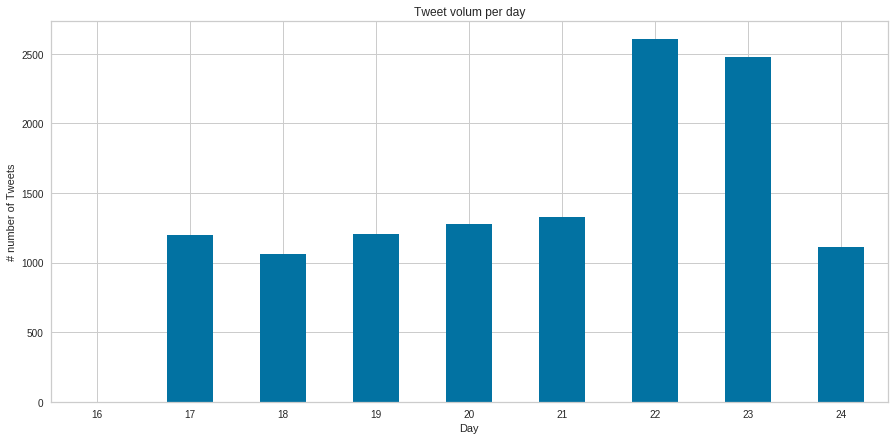

In [8]:
X = tweets['tweet_created']

fig, ax = plt.subplots(figsize=(15,7))
X.groupby([X.dt.day]).count().plot(kind="bar")
ax.set_title('Tweet volum per day')
ax.set_ylabel("# number of Tweets")
ax.set_xlabel("Day")
plt.xticks(rotation = 0)


### 4.4) Tweet volum per hour and per day


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0, 0.5, '# number of Tweets')

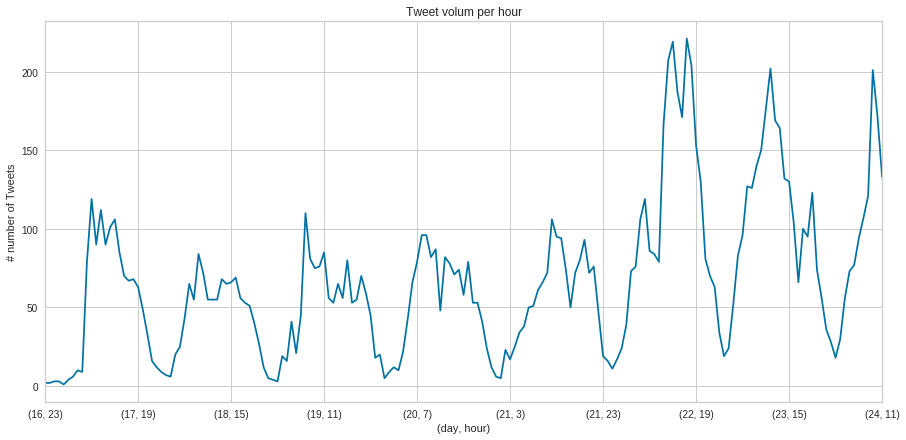

In [9]:
df = tweets[['tweet_created', 'airline_sentiment_confidence']]
df['tweet_created'] = pd.to_datetime(df['tweet_created'])
X = df['tweet_created']

fig, ax = plt.subplots(figsize=(15,7))
X.groupby([X.dt.day,X.dt.hour]).count().plot(ax=ax)
ax.set_title('Tweet volum per hour')
ax.set_xlabel("(day, hour)")
ax.set_ylabel("# number of Tweets")


In [10]:
from bs4 import BeautifulSoup
import requests

accounts = ('jnardino', 'cairdin', 'yvonnalynn')

for account in accounts:
    url = 'https://www.twitter.com/' + account
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "lxml")

    f = soup.find('li', class_="ProfileNav-item--followers")
    title = f.find('a')['title']
    print(list((title, account)))

['7,724 Followers', 'jnardino']
['517 Followers', 'cairdin']
['1,822 Followers', 'yvonnalynn']


### 4.7) World cloud

#### 4.7.1) Draw wordcloud function

The **`draw_wordcloud`** function allows to plot the drawcloud according to the sentiment analysis:

**Arguments**: 
*   `sentiment`: string representing the sentiment. The possible values are: `('positive', 'negative', 'neutral')`. 

In [0]:
def draw_wordcloud(sentiment):
    sentiment_tweets  =tweets[tweets['airline_sentiment']== sentiment]
    words = ' '.join(sentiment_tweets['text'])
    cleaned_word = " ".join([word for word in words.split() if 'http' not in word and not word.startswith('@') and word != 'RT'])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=3000, height=2500).generate(cleaned_word)
    plt.figure(1,figsize=(15,15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

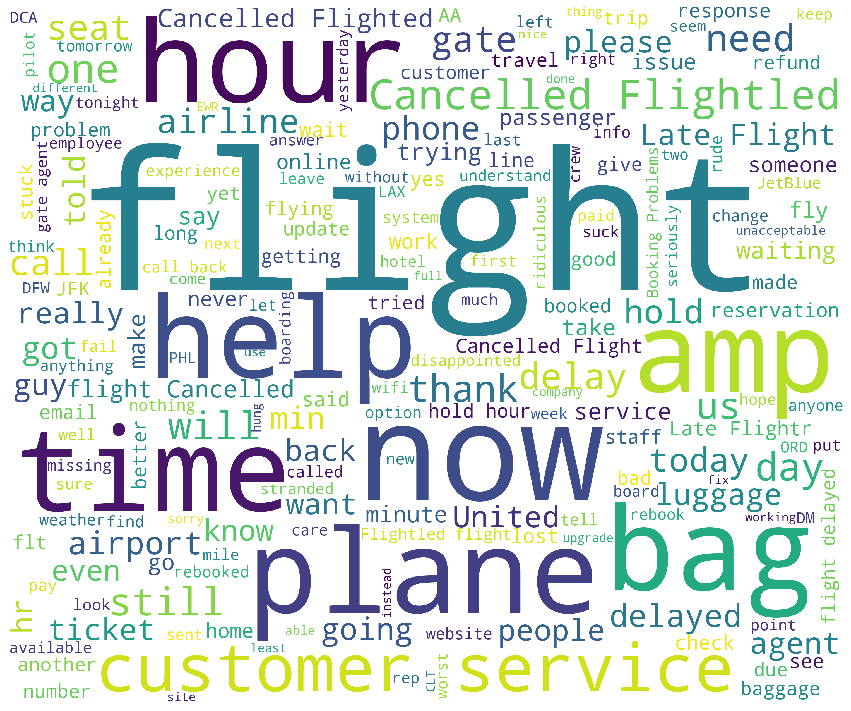

In [12]:
draw_wordcloud('negative')

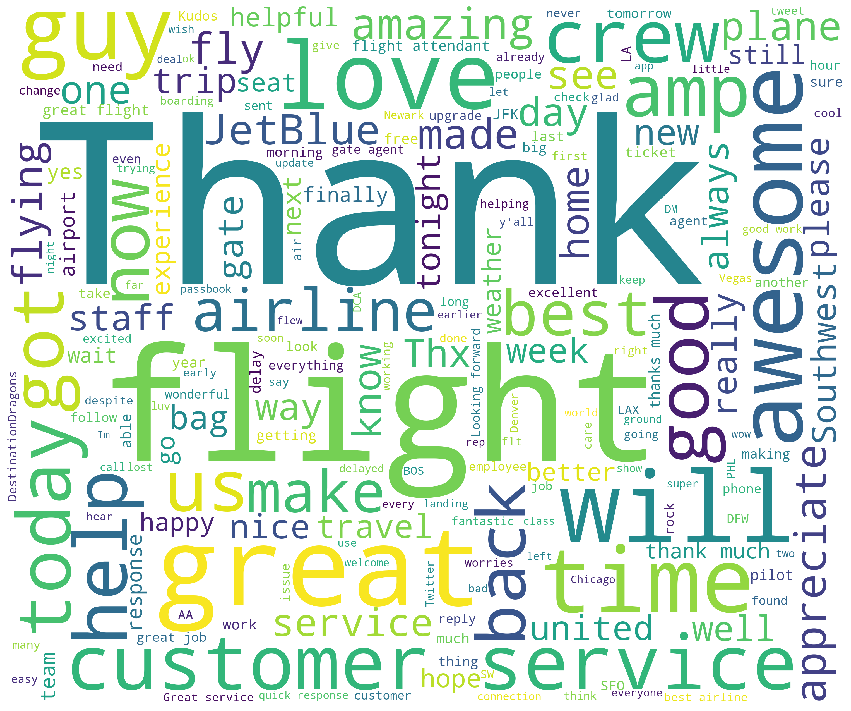

In [13]:
draw_wordcloud('positive')

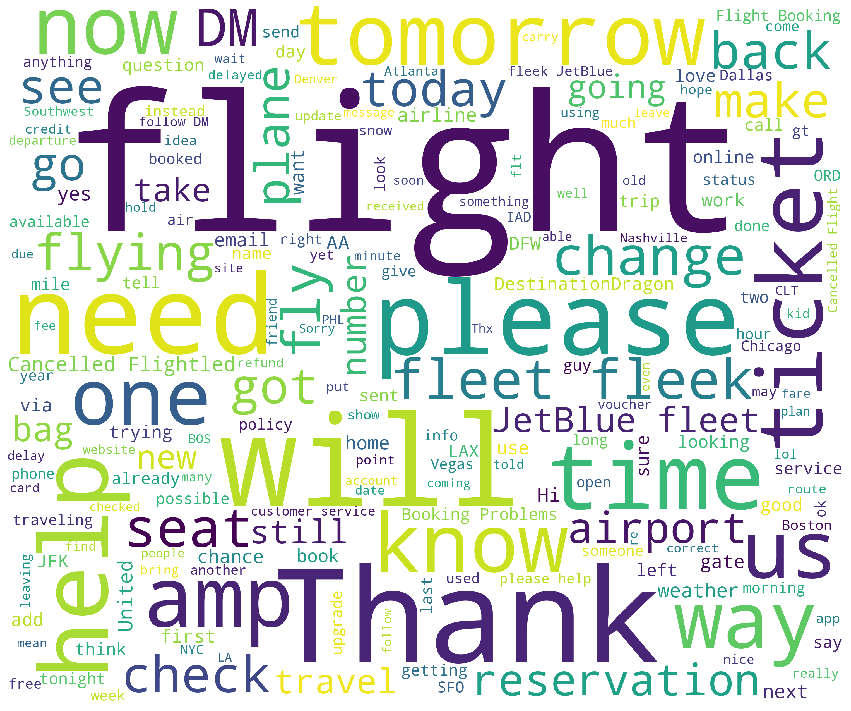

In [14]:
draw_wordcloud('neutral')